In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [62]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442400146024_engineered.csv')
# buat df baru hanya READ_DATE dan KWH_EXP saja
df = df[['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss']]
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss
READ_DATE,,,,,,,,,,,
2019-01-01,0.000000,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5
2019-01-02,0.076469,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7
2019-01-03,0.310542,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1
2019-01-04,0.066232,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1
2019-01-05,1.070875,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,39.352355,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4
2024-05-28,36.329893,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2
2024-05-29,43.653419,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7


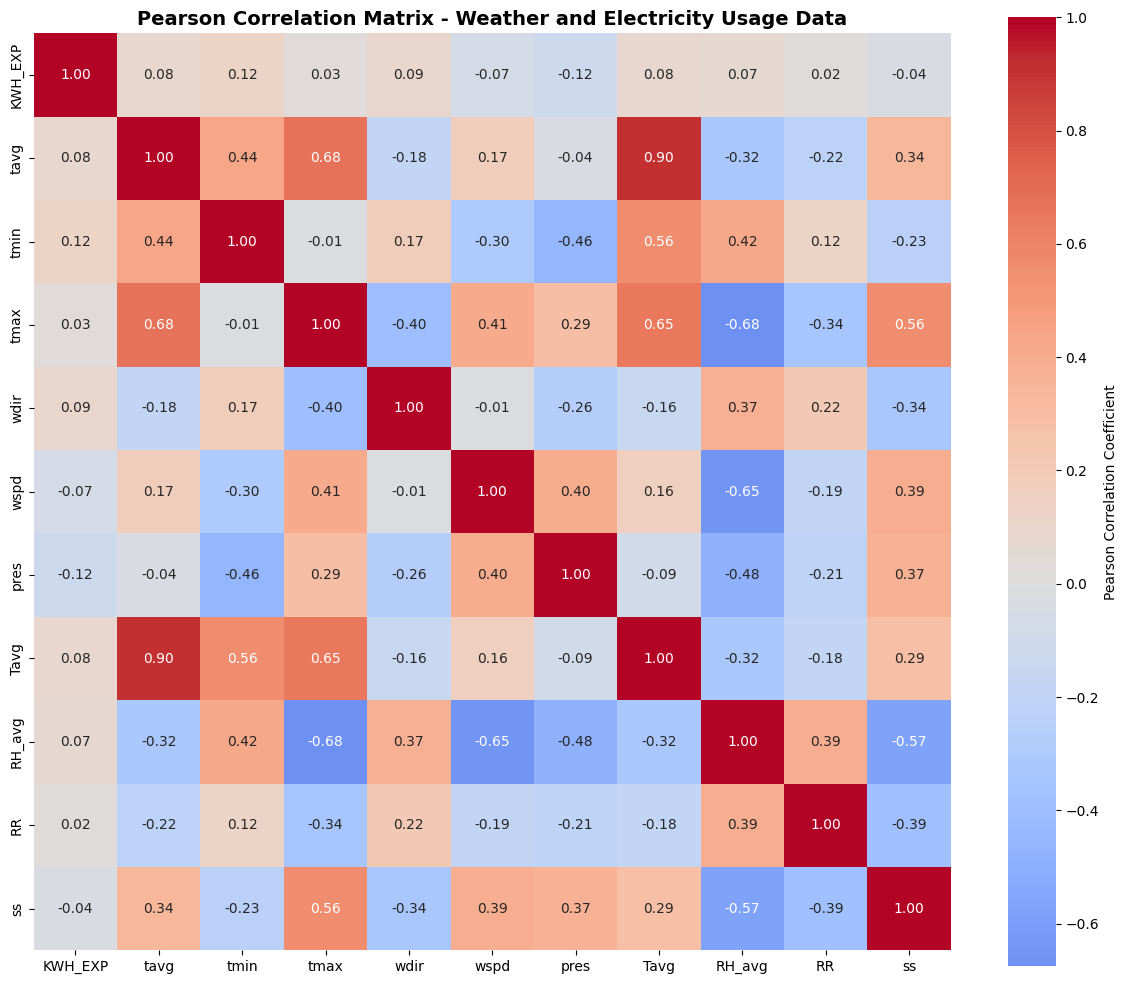

Correlation with KWH_EXP:
KWH_EXP    1.000000
tmin       0.121137
wdir       0.085611
Tavg       0.082325
tavg       0.078864
RH_avg     0.069738
tmax       0.028558
RR         0.023300
ss        -0.039144
wspd      -0.065481
pres      -0.120395
Name: KWH_EXP, dtype: float64


In [63]:
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,  # Tampilkan nilai korelasi
            cmap='coolwarm',  # Color map
            center=0,  # Pusat skala warna di 0
            square=True,  # Bentuk kotak
            fmt='.2f',  # Format angka 2 desimal
            cbar_kws={'label': 'Pearson Correlation Coefficient'})

plt.title('Pearson Correlation Matrix - Weather and Electricity Usage Data',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation with KWH_EXP:")
print(correlation_matrix['KWH_EXP'].sort_values(ascending=False))

In [64]:
df = df[['KWH_EXP', 'tmax', 'tmin', 'wdir', 'tavg', 'RH_avg']]
df

,KWH_EXP,tmax,tmin,wdir,tavg,RH_avg
READ_DATE,,,,,,
2019-01-01,0.000000,30.2,24.8,44.0,25.7,96.0
2019-01-02,0.076469,29.2,24.1,21.0,26.0,90.0
2019-01-03,0.310542,27.3,24.0,340.0,24.6,94.0
2019-01-04,0.066232,29.8,23.0,340.0,26.2,88.0
2019-01-05,1.070875,30.2,23.6,284.0,26.9,88.0
...,...,...,...,...,...,...
2024-05-27,39.352355,34.0,24.4,126.0,28.3,73.0
2024-05-28,36.329893,33.9,24.1,125.0,28.2,75.0
2024-05-29,43.653419,33.0,24.2,130.0,29.0,77.0


In [65]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE KWH_EXP	tavg	tmin	tmax	wdir	wspd	pres	Tavg	RH_avg	RR	ss
019-01-01	1.704497	25.7	24.8	30.2	44.0	6.4	1008.9	25.7	96.0	12.9	7.5
2019-01-02	1.804380	26.0	24.1	29.2	21.0	5.4	1009.2	25.9	90.0	42.7	6.7
2019-01-03	1.606232	24.6	24.0	27.3	340.0	4.1	1010.3	24.9	94.0	0.5	0.1
2019-01-04	1.220510	26.2	23.0	29.8	340.0	6.9	1011.4	25.8	88.0	34.6	0.1
2019-01-05	0.980424	26.9	23.6	30.2	284.0	6.3	1011.7	26.7	88.0	2.1	3.2
"""


train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [66]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [67]:
train_scaled_features

array([[-1.81016219, -1.55236723,  1.02028777, -1.6810988 , -1.718197  ,
         2.07250172],
       [-1.80707531, -2.13049838,  0.46910278, -2.05933506, -1.43304526,
         1.37724213],
       [-1.79762633, -3.22894758,  0.39036207,  3.18663736, -2.76375338,
         1.84074852],
       ...,
       [ 0.26388659, -1.55236723,  0.54784349,  2.64395056, -1.52809584,
         1.37724213],
       [ 0.16322783, -3.22894758,  0.39036207,  2.44660991, -1.52809584,
         1.84074852],
       [ 0.03692467, -0.80079673,  1.02028777,  2.61106045, -0.19738772,
         0.56610595]])

In [68]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [69]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 19: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


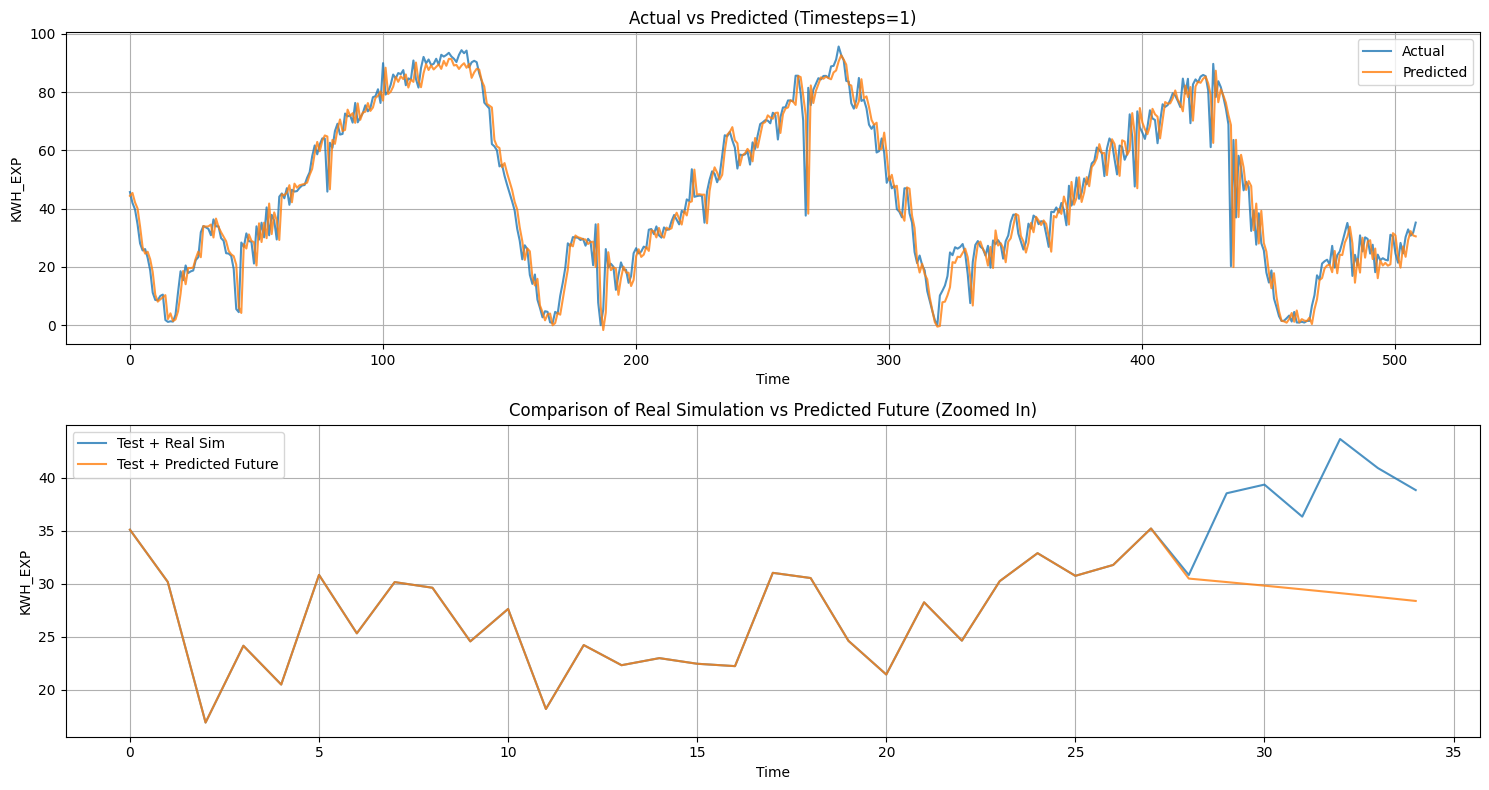


Metrics for timesteps=1:
MSE: 50.1134
R²: 0.9278
MAPE: 60850996447888.0391
MAE: 4.5080
Training time for timesteps = 1: 8.33 seconds

Training model with selected features and timesteps = 2
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


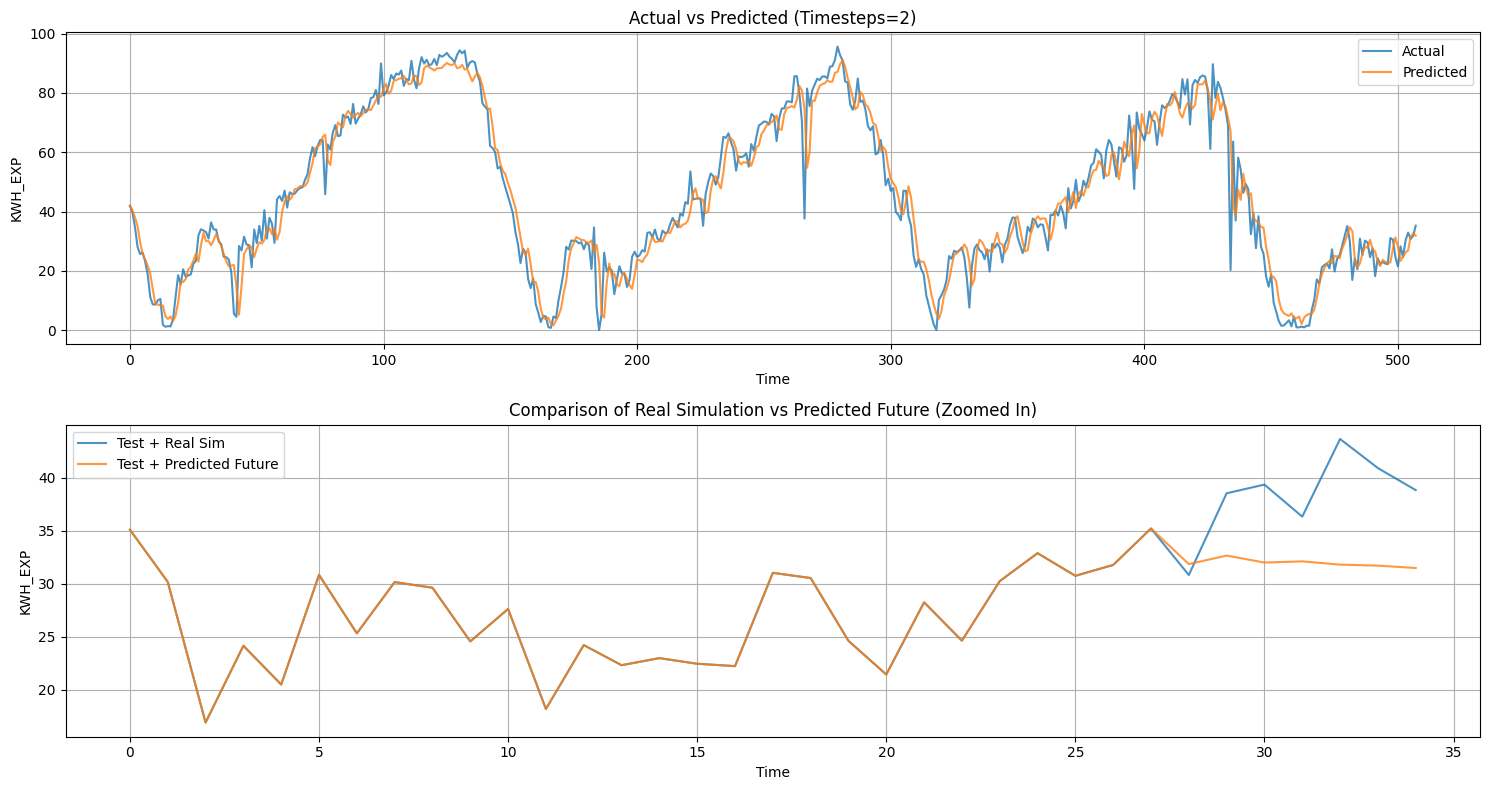


Metrics for timesteps=2:
MSE: 43.7866
R²: 0.9370
MAPE: 249747267011721.3125
MAE: 4.6144
Training time for timesteps = 2: 8.15 seconds

Training model with selected features and timesteps = 3
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


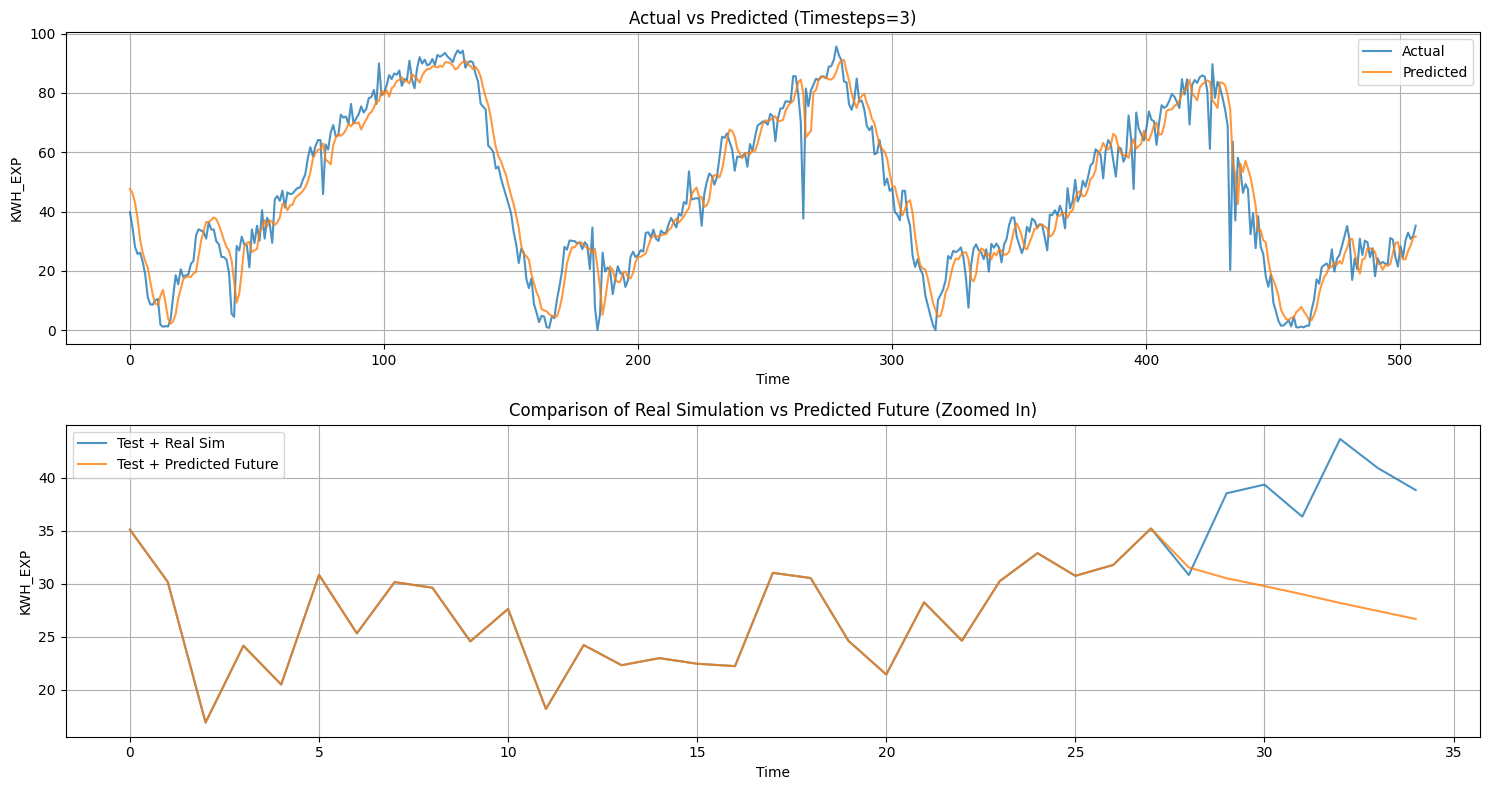


Metrics for timesteps=3:
MSE: 51.0806
R²: 0.9267
MAPE: 248401093945994.6562
MAE: 5.2206
Training time for timesteps = 3: 7.21 seconds

Training model with selected features and timesteps = 4
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


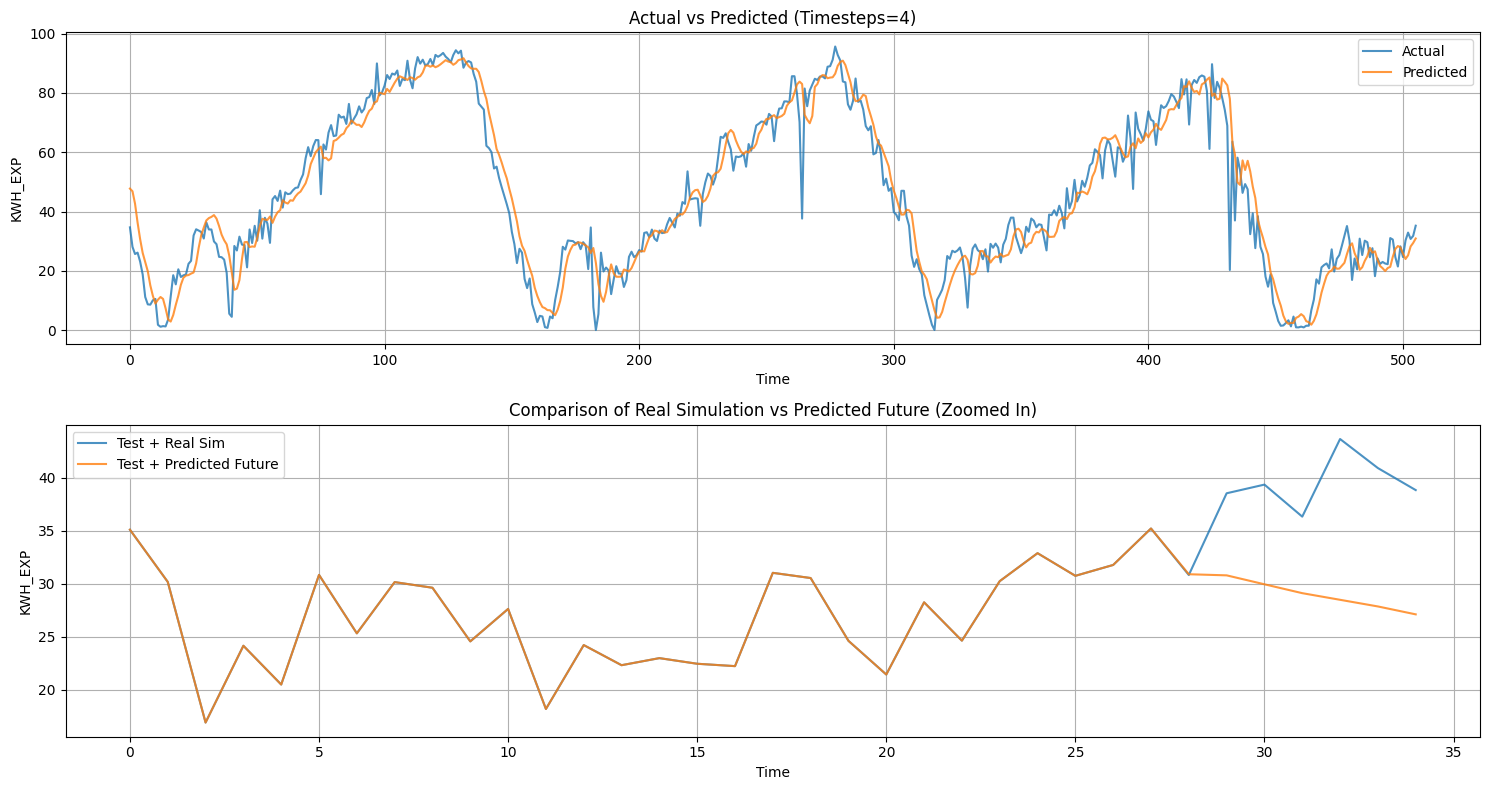


Metrics for timesteps=4:
MSE: 57.6154
R²: 0.9175
MAPE: 261123223250094.3438
MAE: 5.6232
Training time for timesteps = 4: 8.08 seconds

Training model with selected features and timesteps = 5
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


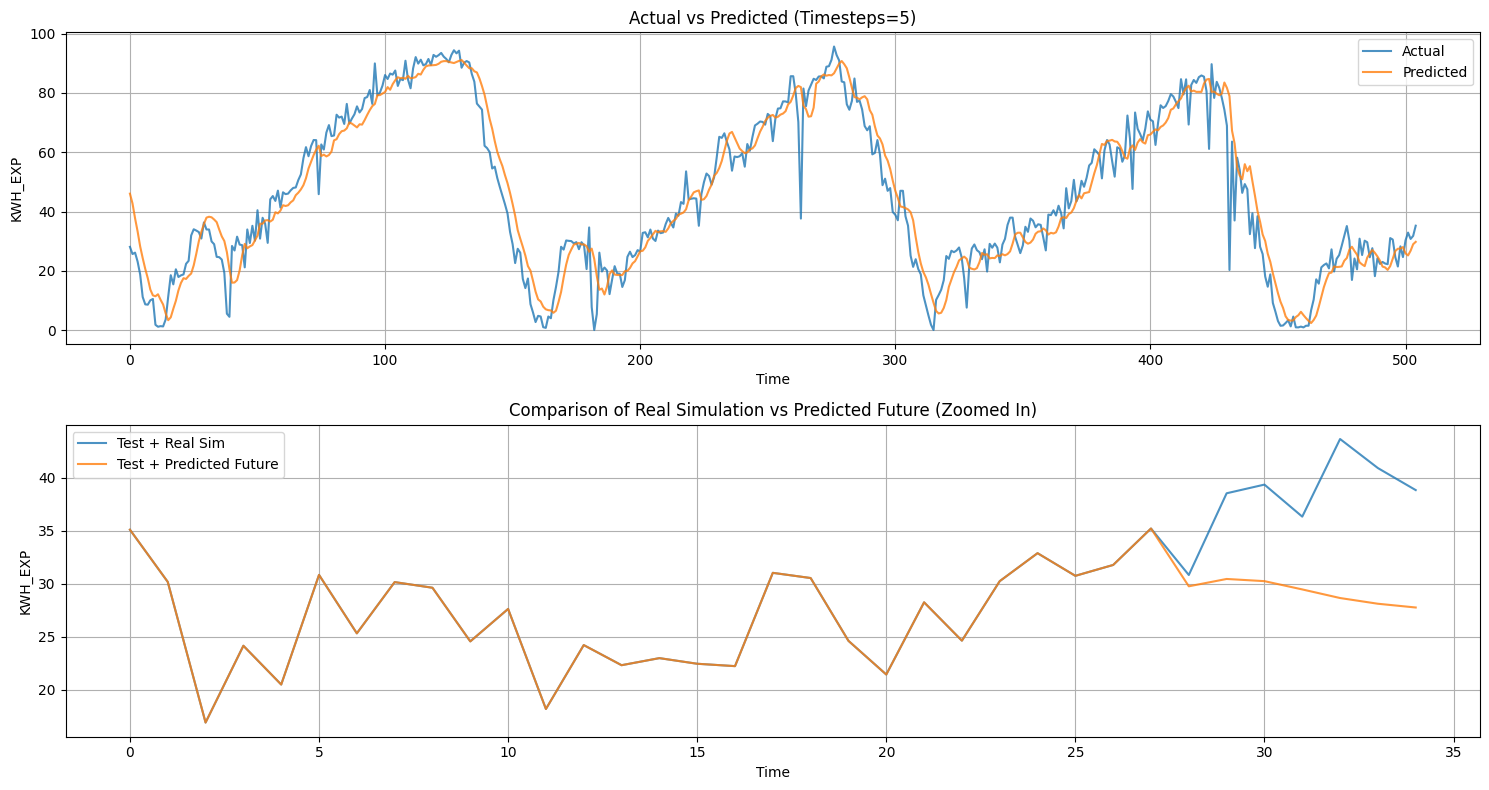


Metrics for timesteps=5:
MSE: 62.9736
R²: 0.9100
MAPE: 295610598589908.8750
MAE: 5.9656
Training time for timesteps = 5: 9.38 seconds

Training model with selected features and timesteps = 6
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


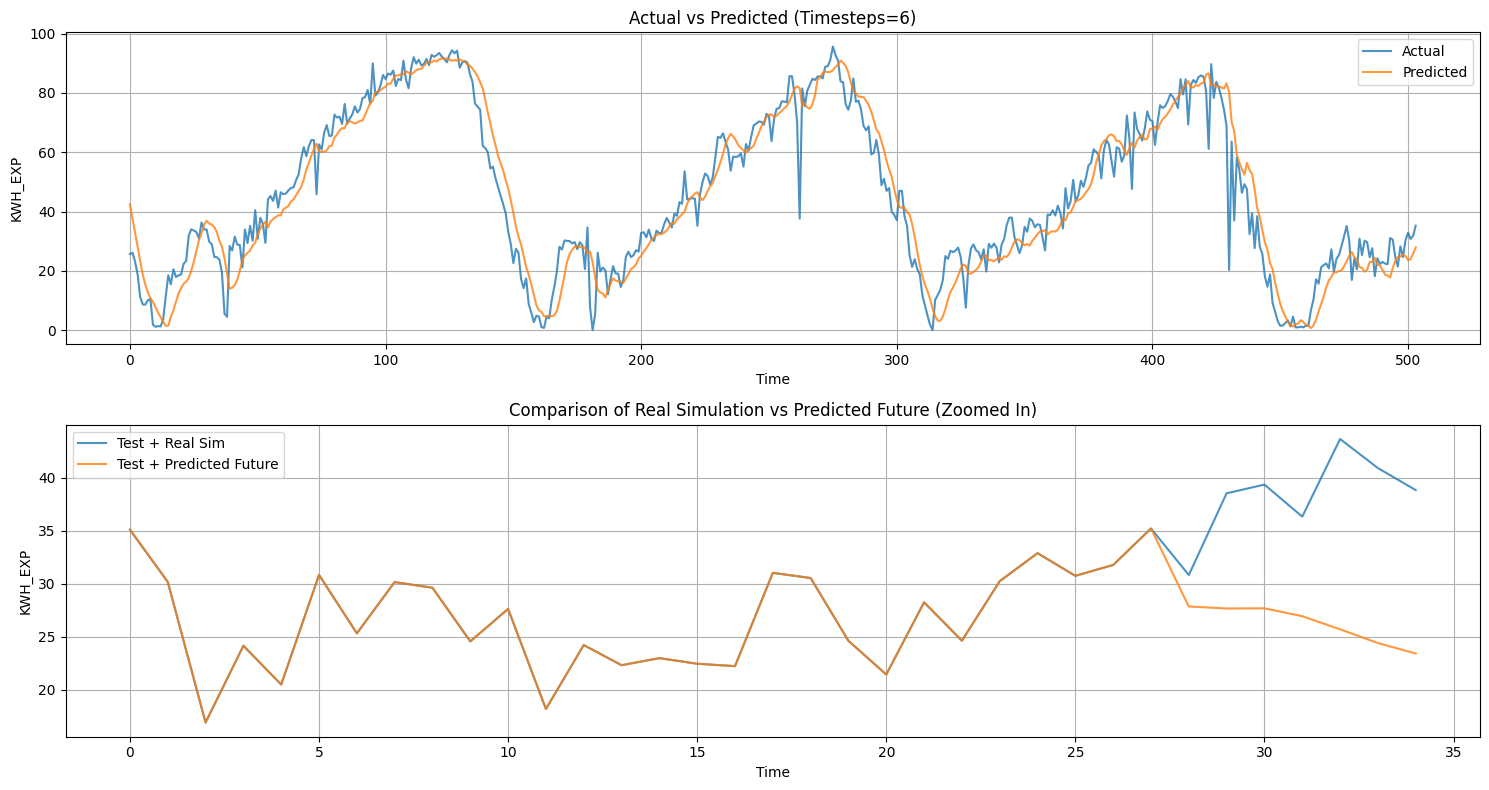


Metrics for timesteps=6:
MSE: 68.9514
R²: 0.9015
MAPE: 268899781164796.2500
MAE: 6.2483
Training time for timesteps = 6: 6.61 seconds

Training model with selected features and timesteps = 7
Epoch 28: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


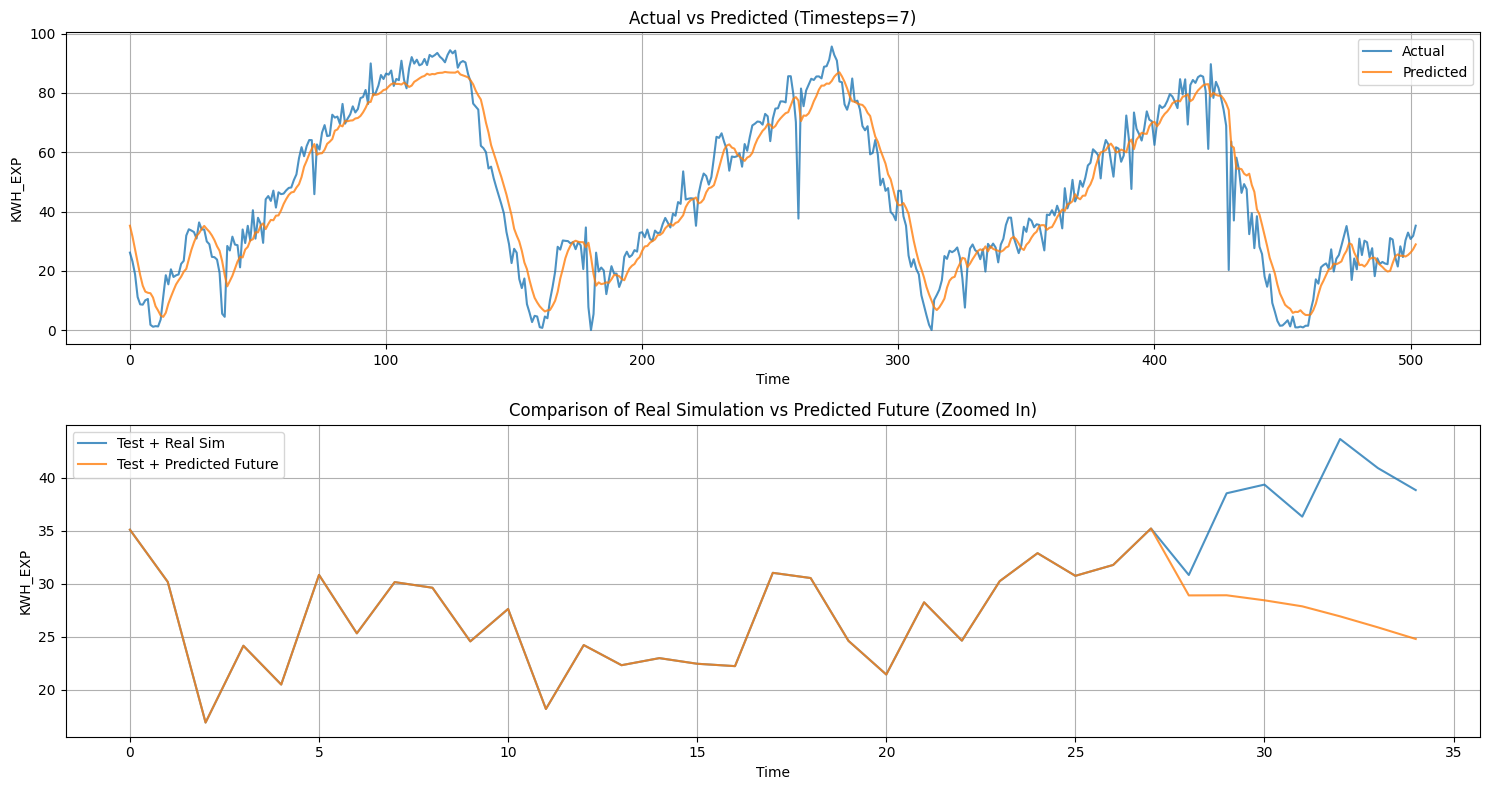


Metrics for timesteps=7:
MSE: 58.2289
R²: 0.9169
MAPE: 309742701018940.9375
MAE: 5.8739
Training time for timesteps = 7: 10.23 seconds
Total training execution time: 57.99 seconds


In [70]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [71]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [72]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 31: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


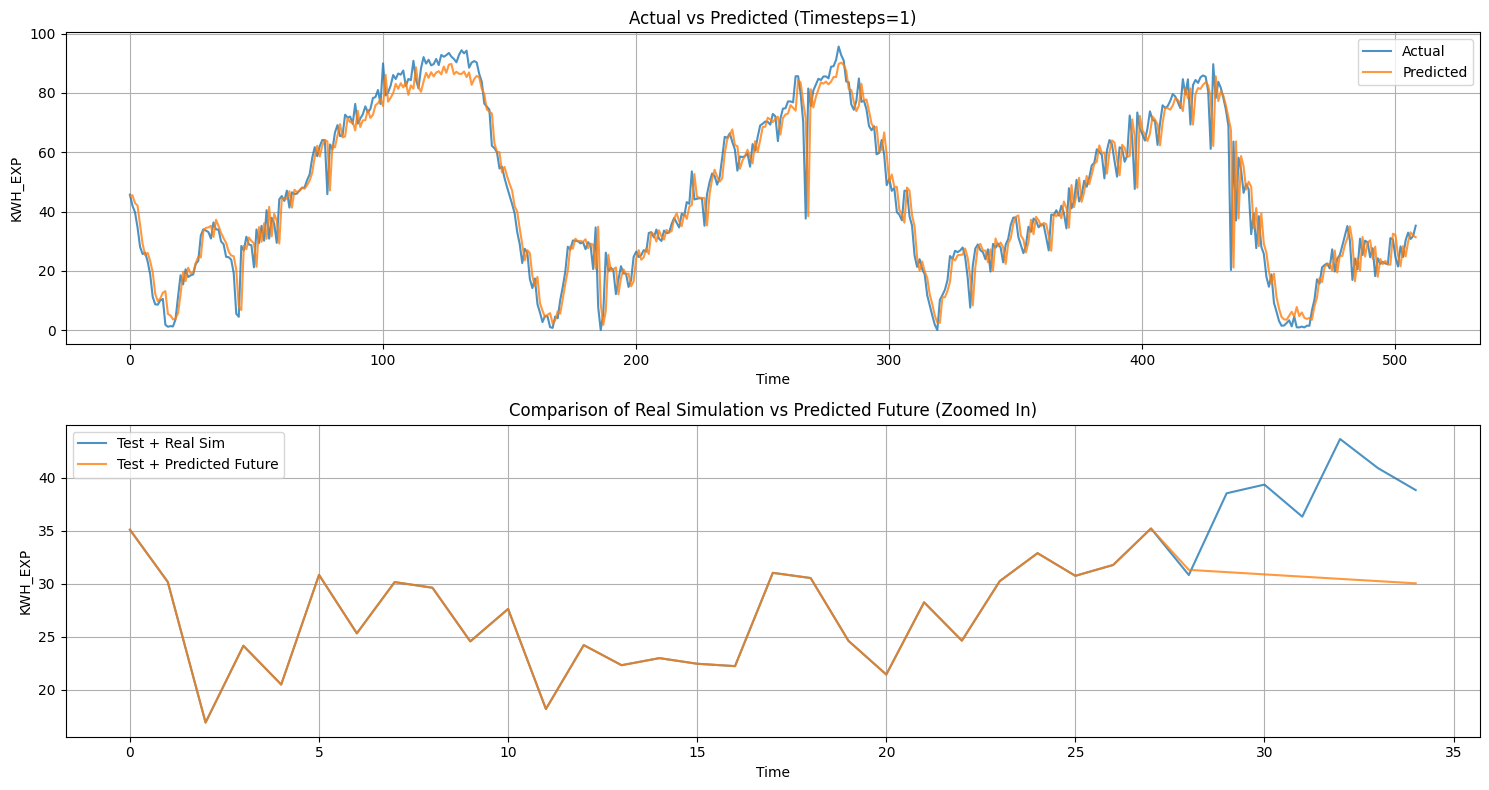


Metrics for timesteps=1:
MSE: 49.6576
R²: 0.9285
MAPE: 100118117828073.1094
MAE: 4.7089
Training time for timesteps = 1: 7.50 seconds

Training model with selected features and timesteps = 3
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


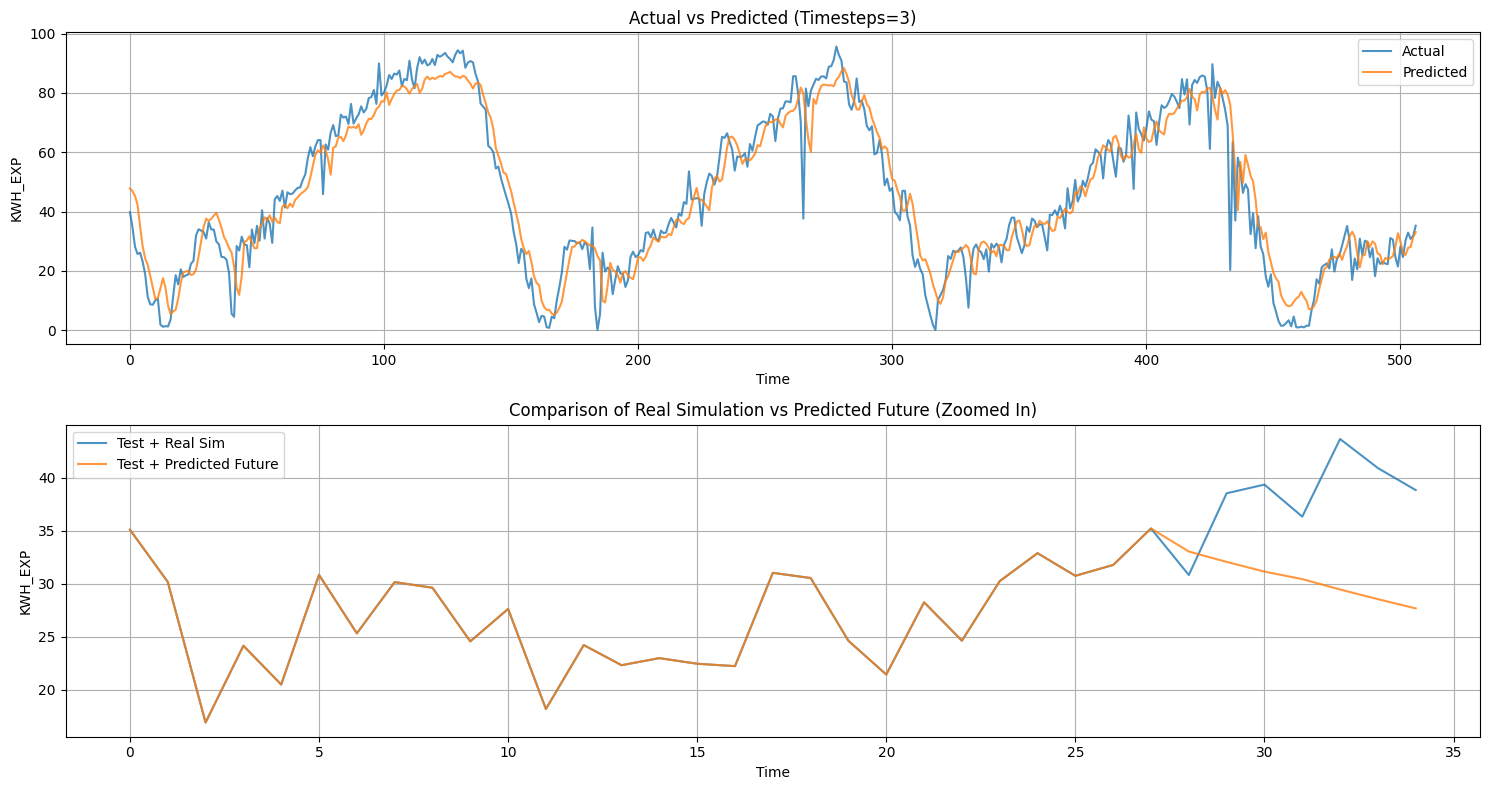


Metrics for timesteps=3:
MSE: 64.0788
R²: 0.9080
MAPE: 334160069830305.0625
MAE: 6.1201
Training time for timesteps = 3: 5.53 seconds

Training model with selected features and timesteps = 3
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


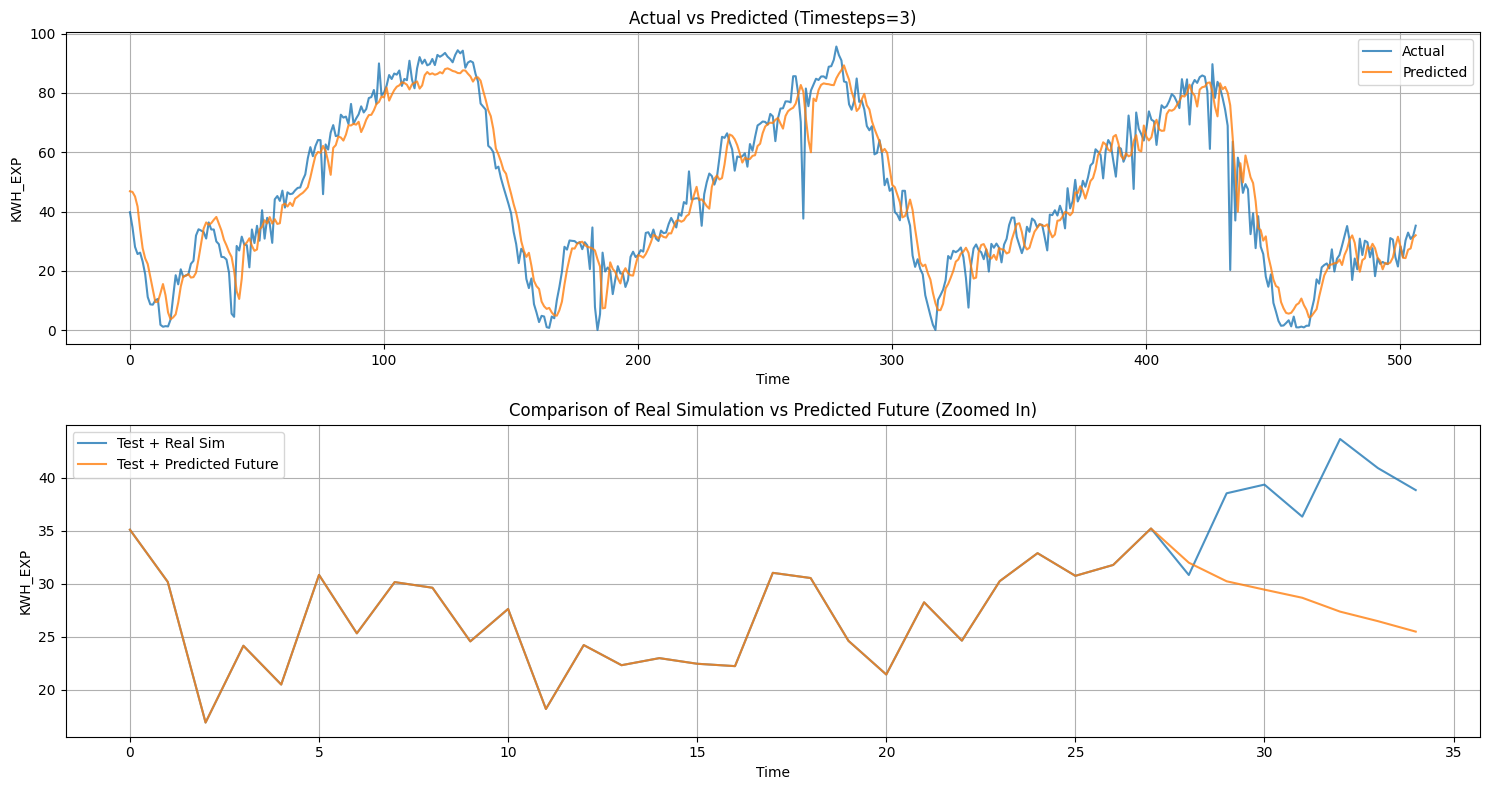


Metrics for timesteps=3:
MSE: 59.2745
R²: 0.9149
MAPE: 292358161227307.8750
MAE: 5.8129
Training time for timesteps = 3: 6.09 seconds

Training model with selected features and timesteps = 4
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


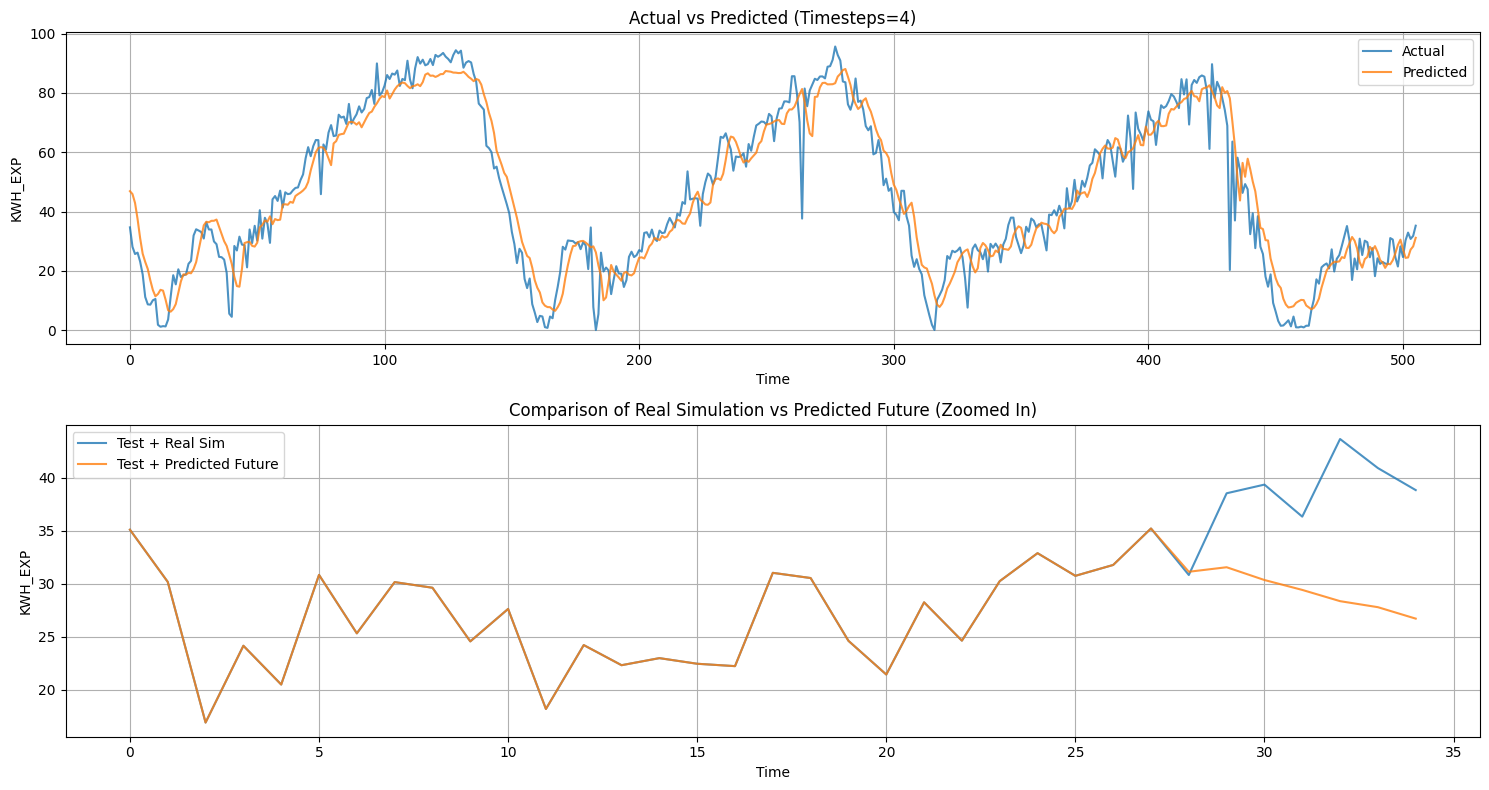


Metrics for timesteps=4:
MSE: 66.7802
R²: 0.9044
MAPE: 336952059191846.8750
MAE: 6.3181
Training time for timesteps = 4: 5.84 seconds

Training model with selected features and timesteps = 5
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


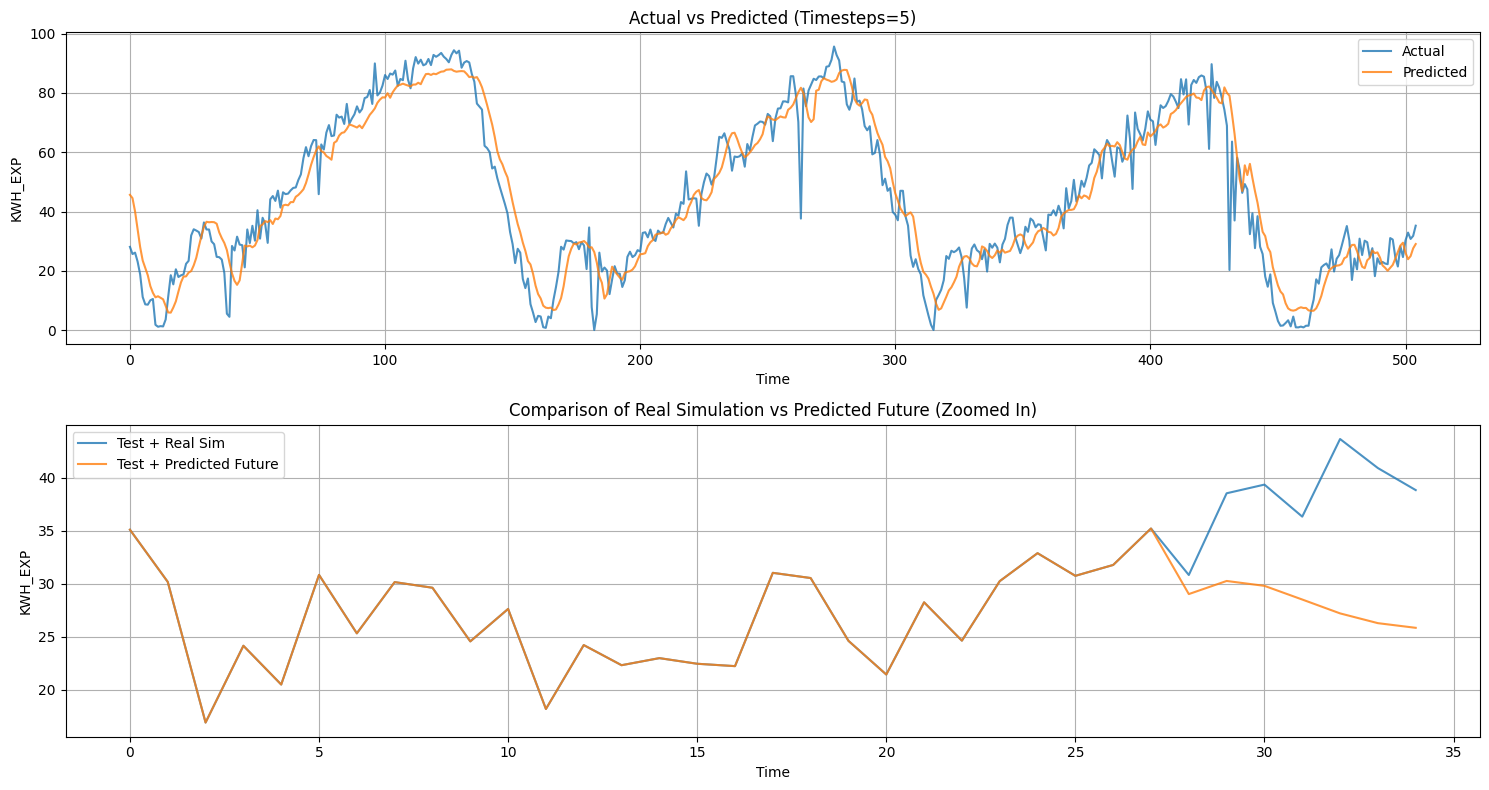


Metrics for timesteps=5:
MSE: 71.2471
R²: 0.8981
MAPE: 343748268857819.0000
MAE: 6.5542
Training time for timesteps = 5: 4.78 seconds

Training model with selected features and timesteps = 6
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


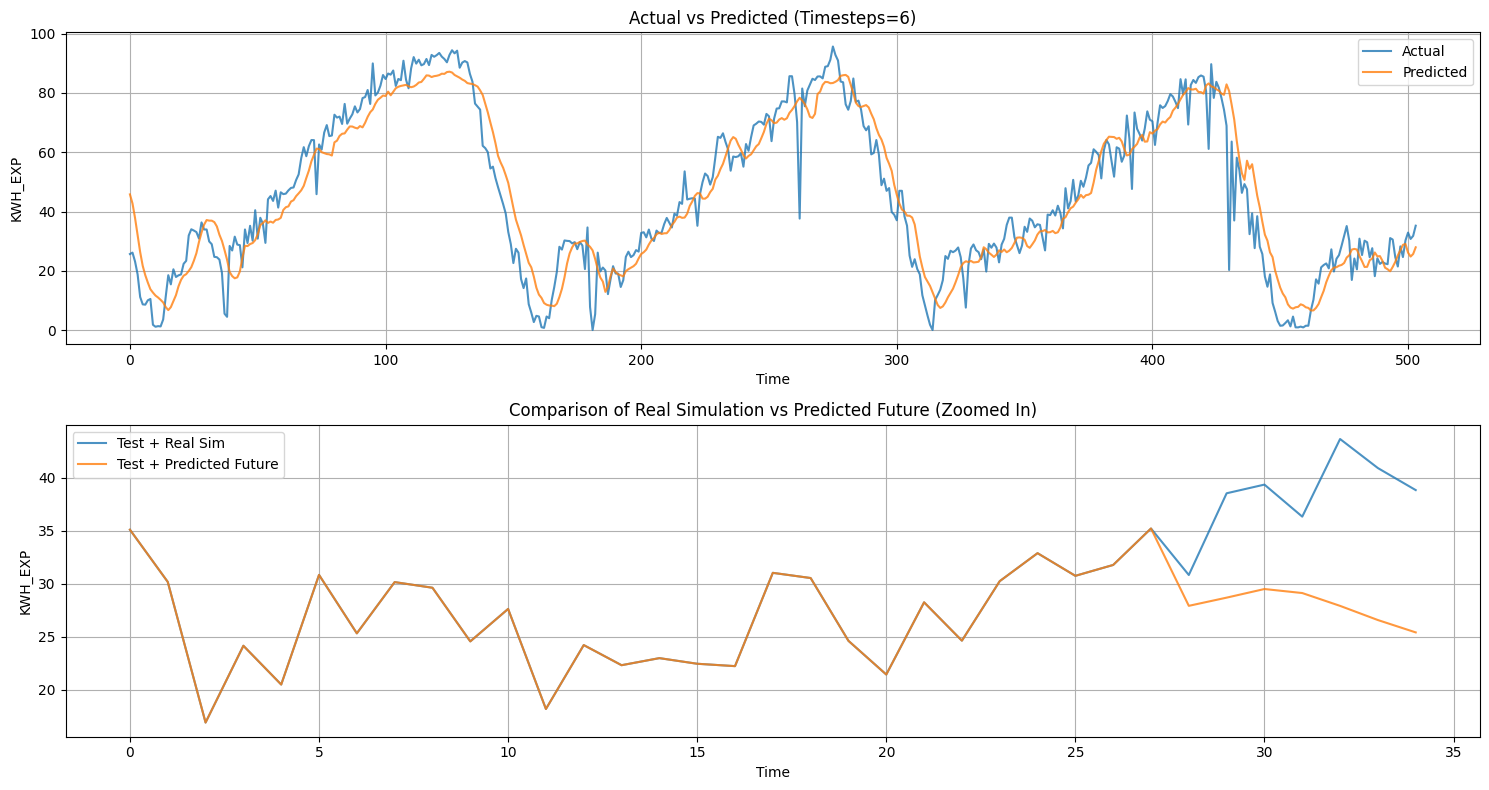


Metrics for timesteps=6:
MSE: 79.3785
R²: 0.8866
MAPE: 353706824866410.1875
MAE: 7.0171
Training time for timesteps = 6: 6.03 seconds

Training model with selected features and timesteps = 7
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


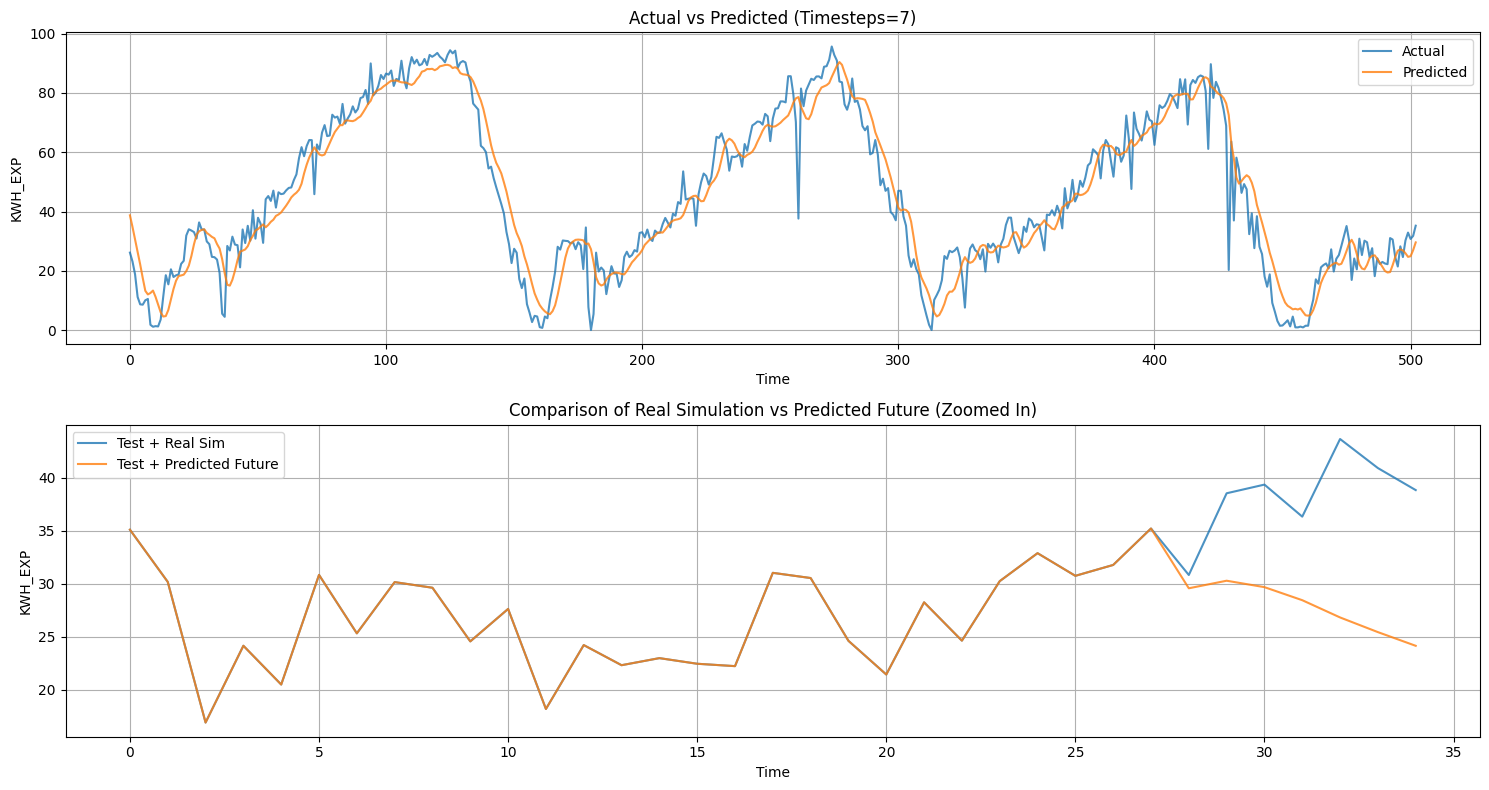


Metrics for timesteps=7:
MSE: 63.6538
R²: 0.9092
MAPE: 322024650977239.7500
MAE: 6.1487
Training time for timesteps = 7: 9.87 seconds
Total training execution time: 45.64 seconds


In [73]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")